In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./Diplomatic_Exchange_2006v1.csv')

In [3]:
df.head()

,ccode1,ccode2,year,DR_at_1,DR_at_2,DE,version
0,2,20,1920,0,0,0,2006.099976
1,2,20,1925,0,0,0,2006.099976
2,2,20,1930,0,2,1,2006.099976
3,2,20,1935,2,2,1,2006.099976
4,2,20,1940,2,2,1,2006.099976


In [4]:
# Create your connection.
conn = sqlite3.connect('diplomatic.db')

In [5]:
# # dump pandas to db
# df.to_sql(name='diplomatic_exchages', con=conn)

In [5]:
q = """
    select * from diplomatic_exchages de
    where year = 2005 and DE = 1 and DR_at_1 = 3
"""
df_2005 = pd.read_sql(q, conn)

In [6]:
df_2005.head()

,index,ccode1,ccode2,year,DR_at_1,DR_at_2,DE,version
0,16,2,20,2005,3,3,1,2006.099976
1,23,2,31,2005,3,3,1,2006.099976
2,69,2,41,2005,3,3,1,2006.099976
3,90,2,42,2005,3,3,1,2006.099976
4,99,2,51,2005,3,3,1,2006.099976


In [7]:
# Create directed graph
%time G = nx.from_pandas_edgelist(df_2005[['ccode1', 'ccode2']], source = 'ccode1', target = 'ccode2', create_using=nx.DiGraph)

Wall time: 25 ms


In [8]:
# adjacency matrix
H = nx.adjacency_matrix(G)
H

<192x192 sparse matrix of type '<class 'numpy.intc'>'
	with 7517 stored elements in Compressed Sparse Row format>

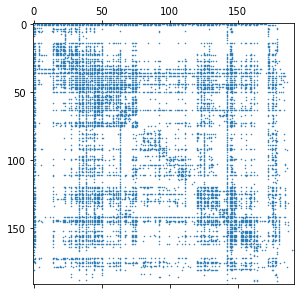

In [9]:
# plot adjacency matrix
fig, ax = plt.subplots(1,1, figsize=(6.4, 4.8))
ax.spy(H, markersize =1, marker = '.')

In [10]:
page_rank_scores_dict = nx.pagerank(G, tol=1e-02) 

In [11]:
page_rank_scores = [page_rank_scores_dict[node] for node in page_rank_scores_dict]

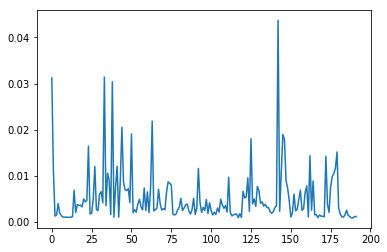

In [12]:
# plot pagerank scores
plt.plot(page_rank_scores)

In [13]:
import csv

In [14]:
with open('./COW-country-codes.csv', 'r') as f:
    country_codes_dict = {int(row['CCode']): row['StateNme'] for row in csv.DictReader(f)}

In [15]:
# country codes maping
country_codes_dict[2]

'United States of America'

In [17]:
# plt.hist(page_rank_scores)

In [16]:
# Sort the dictionary by values
page_rank_scores_dict_sorted = dict(sorted(page_rank_scores_dict.items(), key=lambda x: x[1], reverse=True))

C:\Users\LoizosLaptop\.conda\envs\py3711\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


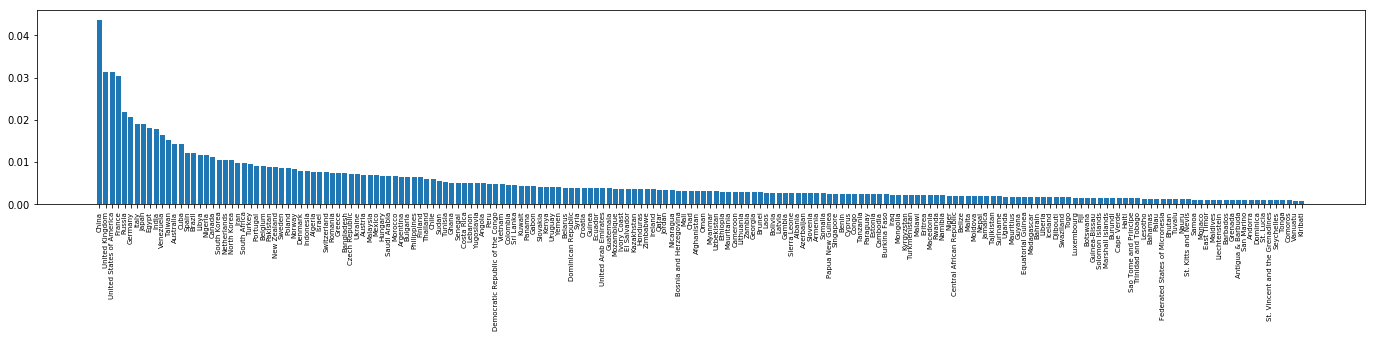

In [19]:
fig, ax = plt.subplots(1,1, figsize=(3*6.4, 4.8), tight_layout=True)

plt.bar(list(map(lambda x: country_codes_dict[x], page_rank_scores_dict_sorted.keys())), page_rank_scores_dict_sorted.values())
plt.xticks(rotation=90, fontsize=7);
fig.savefig('2005_pagerank.png', dpi=300)
# ax.tick_params(axis='x', which='major', labelsize=8)

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1,10))

In [18]:
page_rank_scores_scaled = scaler.fit_transform(np.array(page_rank_scores).reshape(-1,1)).flatten()

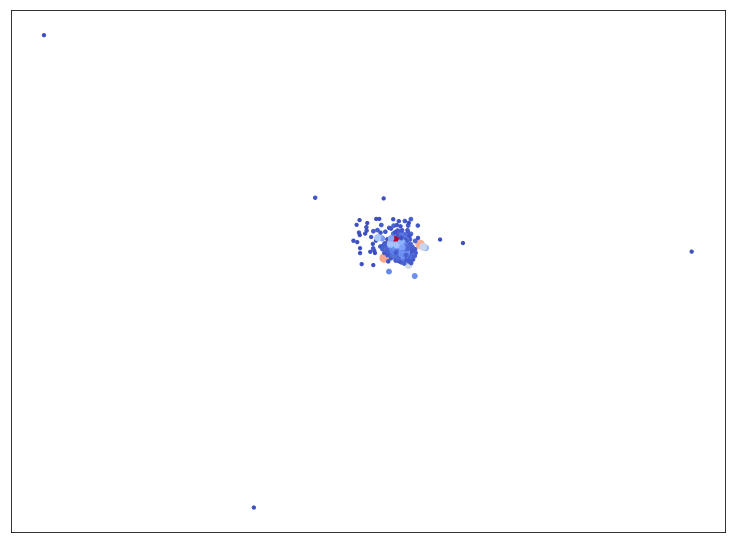

In [23]:
fig, ax = plt.subplots(1,1, figsize=(2*6.4, 2*4.8))

# layout = nx.random_layout(G, seed=42)
layout = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos=layout, node_size = 10*page_rank_scores_scaled,
node_color = page_rank_scores_scaled, cmap='coolwarm', ax=ax)

In [24]:
# check the top 10 nodes graph

In [81]:
country_codes_dict[365], country_codes_dict[710]

('Russia', 'China')

In [80]:
top_10_nodes

[710, 200, 2, 220, 365, 255, 325, 740, 651, 750]

In [19]:
top_10_nodes = list(page_rank_scores_dict_sorted.keys())[:10]
top10_subgraph = G.subgraph(top_10_nodes)

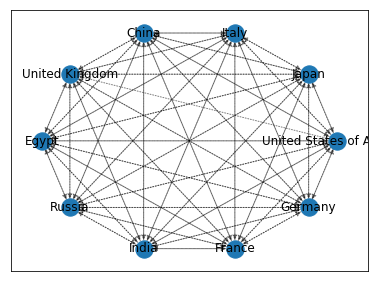

In [20]:
# nx.draw(top10_subgraph)
fig, ax = plt.subplots(1,1, figsize=(6.4, 4.8))
layout = nx.circular_layout(top10_subgraph)#, seed=42)
# nx.draw_networkx(top10_subgraph, layout)
nx.draw_networkx_nodes(top10_subgraph, pos=layout, ax=ax)#,node_size = 50*page_rank_scores_scaled, node_color = page_rank_scores_scaled, cmap='coolwarm', ax=ax)
nx.draw_networkx_edges(top10_subgraph, pos=layout, alpha=0.5,ax=ax, style='dotted');
nx.draw_networkx_labels(top10_subgraph, layout, {i: country_codes_dict[i] for i in top10_subgraph.nodes()}, ax=ax);

In [26]:
nx.adjacency_matrix(top10_subgraph).todense()

In [33]:
# list(top10_subgraph.edges)

In [31]:
(365, 710) in list(top10_subgraph.edges)
(710, 365) in list(top10_subgraph.edges)

True

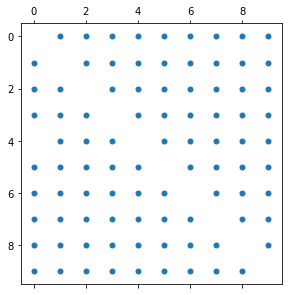

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6.4, 4.8))
ax.spy(nx.adjacency_matrix(top10_subgraph), markersize =10, marker = '.')

In [126]:
# check the top 3 nodes connections with the rest of the nodes

In [27]:
top_3_nodes = list(page_rank_scores_dict_sorted.keys())[:3]
top_3_graph = nx.DiGraph() # actually top 3

# Add the edges between the subset nodes and the rest of the nodes
for node in G.nodes():
    if node in top_3_nodes:
        for neighbor in G.neighbors(node):
            top_3_graph.add_edge(node, neighbor)
            # if neighbor not in top_3_nodes: # dont need this
            #     top_10_graph.add_edge(node, neighbor)

In [140]:
# pos = nx.spring_layout(top_10_graph, seed=42)
# nx.draw(top_10_graph, pos)

In [28]:
filtered_G = nx.DiGraph()

# Add the nodes from the full graph to the filtered graph
for node in G.nodes():
    filtered_G.add_node(node)

# Add the edges from the subset_edges to the filtered graph
for edge in top_3_graph.edges:
    filtered_G.add_edge(*edge)

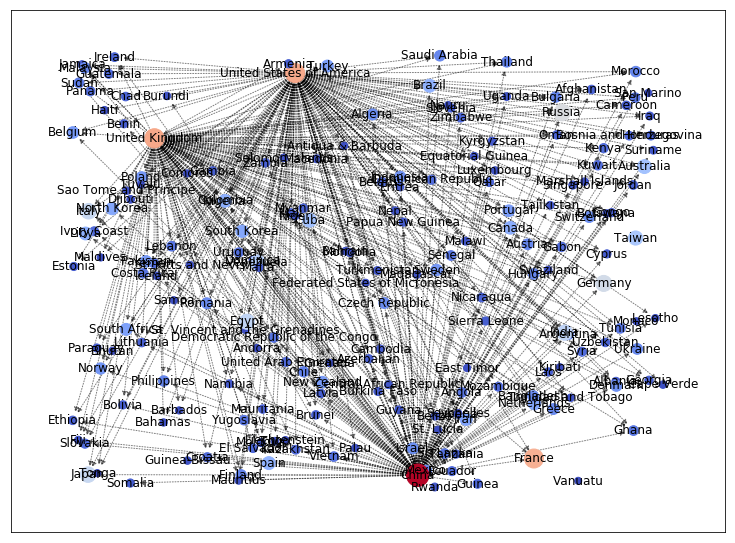

In [60]:
fig, ax = plt.subplots(1,1, figsize=(2*6.4, 2*4.8))

layout = nx.random_layout(G, seed=42)
nx.draw_networkx_nodes(filtered_G, pos=layout,node_size = 50*page_rank_scores_scaled, node_color = page_rank_scores_scaled, cmap='coolwarm', ax=ax)
nx.draw_networkx_edges(filtered_G, pos=layout, alpha=0.5,ax=ax, style='dotted');
nx.draw_networkx_labels(filtered_G, layout, {i: country_codes_dict[i] for i in filtered_G.nodes()}, ax=ax);